# Overview


- **4.0. Overfitting and Underfitting**
  - 4.0.1. *Network size*
  - 4.0.2. *Weights regularization*
  - 4.0.3. *Dropouts*
<br><br>  

- **4.1. TensorboardX**
  





# 4.0. Over-/Underfitting

**Optimization:** process of adjusting a model to get the best performance possible on the training data

**Generalization:** how well trained model performs on data it has never seen before

#### What to do when model is underfitting (not optimal)?
 - Train longer

#### How to prevent overfitting (i.e. generalize)?
 - Get more data
 - Modulate quantity of information fed to model



# 4.0.1. Network Size 


> *“A **small network**, with say one hidden unit is **likely to be biased**, since the repertoire of available functions spanned by 𝑓(𝑥,𝑤)  over allowable weights will in this case be quite limited.”* 

> “if we **overparameterize, via a large number of hidden units and associated weights**, then bias will be reduced (… with enough weights and hidden units, the network will interpolate the data) but there is then the **danger of significant variance** contribution to the mean-square error”


([German et al. 1992](http://web.mit.edu/6.435/www/Geman92.pdf))

Managing the size/capacity of your network in the model, more accurately the no. of learnable parameters (i.e. no. of layers x no. of units per layer), will (i) ***optimize the network to converge faster*** and/or (ii) ***prevent the network from overfitting to the training data***. To illustrate this point, lets go back to our XOR example.


In [1]:
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch import tensor
from torch import optim

#from tensorboardX import SummaryWriter


import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})


torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# XOR gate inputs and outputs.
X = xor_input = tensor([[0,0], [0,1], [1,0], [1,1]]).float().to(device)
Y = xor_output = tensor([[0],[1],[1],[0]]).float().to(device)

# Use tensor.shape to get the shape of the matrix/tensor.
num_data, input_dim = X.shape
print('Inputs Dim:', input_dim) # i.e. n=2 

num_data, output_dim = Y.shape
print('Output Dim:', output_dim) 
print('No. of Data:', num_data) # i.e. n=4

Inputs Dim: 2
Output Dim: 1
No. of Data: 4


## This time lets try different hidden dimensions!

In [3]:
def MLP(hidden_dim, num_epochs=5000):
    # Step 1: Initialization. 
    # Use Sequential to define a simple feed-forward network.
    model = nn.Sequential(
                # Use nn.Linear to get our simple perceptron.
                nn.Linear(input_dim, hidden_dim),
                # Use nn.Sigmoid to get our sigmoid non-linearity.
                nn.Sigmoid(),
                # Second layer neurons.
                nn.Linear(hidden_dim, output_dim),
                nn.Sigmoid()
            ).to(device)
    # Initialize the optimizer
    learning_rate = 0.3
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    # Initialize the loss function.
    criterion = nn.MSELoss()
    # Initialize the stopping criteria
    # For simplicity, just stop training after certain no. of epochs.
    losses = [] # Keeps track of the loses.
    # Step 2-4 of training routine.
    for _e in tqdm(range(num_epochs)):
        # Reset the gradient after every epoch. 
        optimizer.zero_grad() 
        # Step 2: Foward Propagation
        predictions = model(X)
        # Step 3: Back Propagation 
        # Calculate the cost between the predictions and the truth.
        loss = criterion(predictions, Y)
        # Remember to back propagate the loss you've computed above.
        loss.backward()
        # Step 4: Optimizer take a step and update the weights.
        optimizer.step()
        # Log the loss value as we proceed through the epochs.
        if _e % 100 == 0:
            losses.append(loss.data.item())
    return losses

losses_10 = MLP(hidden_dim=10)
losses_100 = MLP(hidden_dim=100)
losses_200 = MLP(hidden_dim=200)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 718.64it/s]




## This seems to fit what we learn, 

Small network with limited memorization capacity underfits and takes longer to coverge (i.e. find the minimum loss).

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

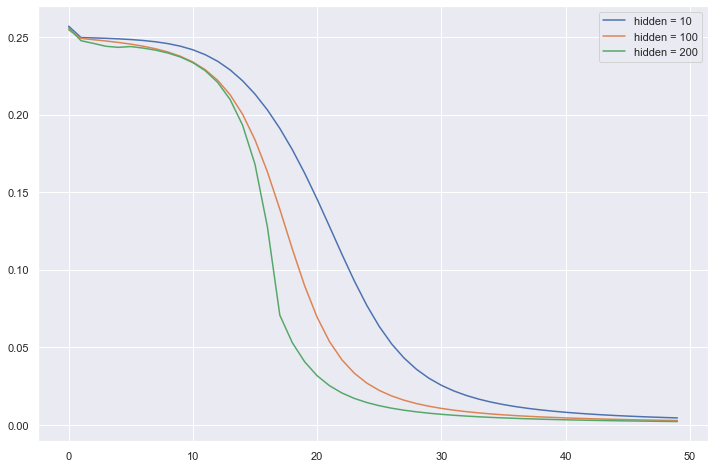

In [5]:
plt.plot(losses_10,  label='hidden = 10')
plt.plot(losses_100, label='hidden = 100')
plt.plot(losses_200, label='hidden = 200')
plt.legend(loc='upper right')
plt.show()

## Now, let's try some larger no. of units

In [6]:
losses_300 = MLP(hidden_dim=300)
losses_1000 = MLP(hidden_dim=1000)
losses_2000 = MLP(hidden_dim=2000)


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 704.72it/s]


## Hey now the curves of larger networks look funky =)

Larger network will converge faster until a certain capacity sweetspot; `hidden_dim=200` converges faster than `hidden_dim=100`, and once it gets to `hidden>=300`, the training loss gets funky.

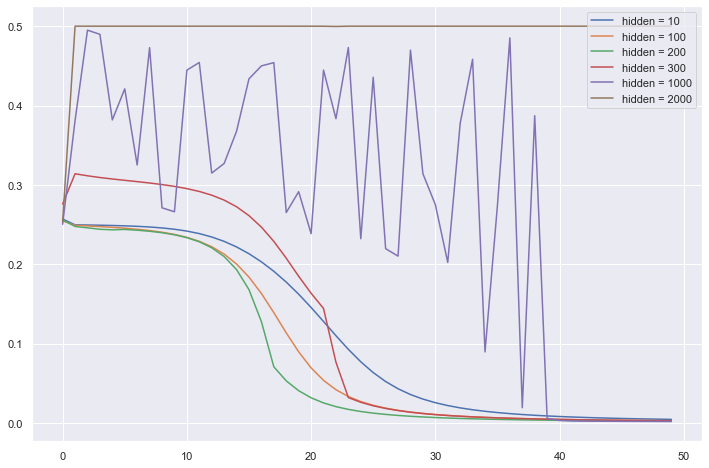

In [7]:
plt.plot(losses_10,  label='hidden = 10')
plt.plot(losses_100, label='hidden = 100')
plt.plot(losses_200, label='hidden = 200')
plt.plot(losses_300, label='hidden = 300')
plt.plot(losses_1000, label='hidden = 1000')
plt.plot(losses_2000, label='hidden = 2000')
plt.legend(loc='upper right')
plt.show()

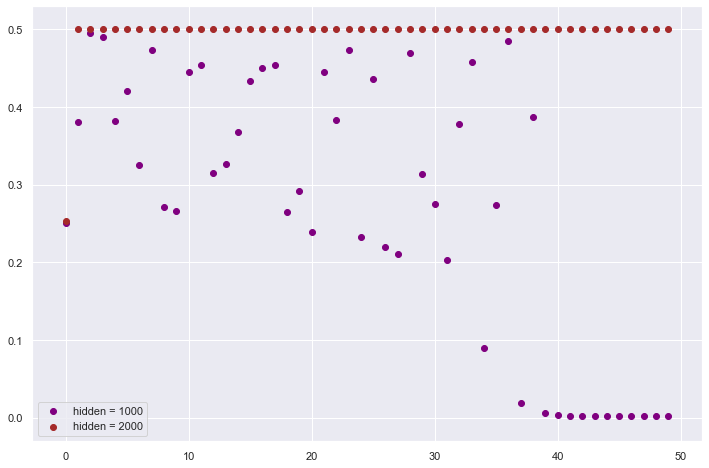

In [8]:
plt.scatter(range(len(losses_1000)), losses_1000, label='hidden = 1000', color='purple')
plt.scatter(range(len(losses_2000)), losses_2000, label='hidden = 2000', color='brown')
plt.legend(loc='lower left')
plt.show()



## Summary:

1. Small network <u>underfits</u> (longer to converge)
2. larger network easier to converge
3. Too large network <u>overfits</u> 
4. Too too large network don't train properly at all.

# 4.0.2. Weights regularization


<img src="http://3.bp.blogspot.com/_oqH68z1KYWk/Stc15KGFpCI/AAAAAAAAARI/ARojEj9rH7o/s1600/occams_professor.gif" width="500" align="left">


The simpler solution is better because makes fewer assumptions. Simpler models are less likely to overfit than complex ones.

By adding a cost associated with large weights, **weights regularization** forces the model weights to take smaller values. 

- ***L1 regularization***: Cost is proportional to the absolute value of the weight coefficient. 

- ***L2 regularization***: Cost is proportional to the square value of the weight coefficient. (L2 regularization is also call *weight decay*

In `PyTorch`, the regularization is a parameter in the optimizer, e.g.

```python
# Using the L2 regularization.
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)
```

IMHO, in practice, I (personally) never tune weights regularization. Other regularization methods gives you better result. L1 Loss is messy in PyTorch, so we'll skip that for now =)


In [11]:
def MLP_L2Loss(hidden_dim, num_epochs=5000, weight_decay=1e-4):
    # Step 1: Initialization. 
    # Use Sequential to define a simple feed-forward network.
    model = nn.Sequential(
                # Use nn.Linear to get our simple perceptron.
                nn.Linear(input_dim, hidden_dim),
                # Use nn.Sigmoid to get our sigmoid non-linearity.
                nn.Sigmoid(),
                # Second layer neurons.
                nn.Linear(hidden_dim, output_dim),
                nn.Sigmoid()
            ).to(device)
    # Initialize the optimizer
    learning_rate = 0.3
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # Initialize the loss function.
    criterion = nn.MSELoss()
    # Initialize the stopping criteria
    # For simplicity, just stop training after certain no. of epochs.
    losses = [] # Keeps track of the loses.
    # Step 2-4 of training routine.
    for _e in tqdm(range(num_epochs)):
        # Reset the gradient after every epoch. 
        optimizer.zero_grad() 
        # Step 2: Foward Propagation
        predictions = model(X)
        # Step 3: Back Propagation 
        # Calculate the cost between the predictions and the truth.
        loss = criterion(predictions, Y)
        # Remember to back propagate the loss you've computed above.
        loss.backward()
        # Step 4: Optimizer take a step and update the weights.
        optimizer.step()
        # Log the loss value as we proceed through the epochs.
        if _e % 100 == 0:
            losses.append(loss.data.item())
    return losses


In [12]:
# Not much different, but subjected to some randomness...
loss_normal = MLP(200)
loss_l2 = MLP_L2Loss(200)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 658.47it/s]


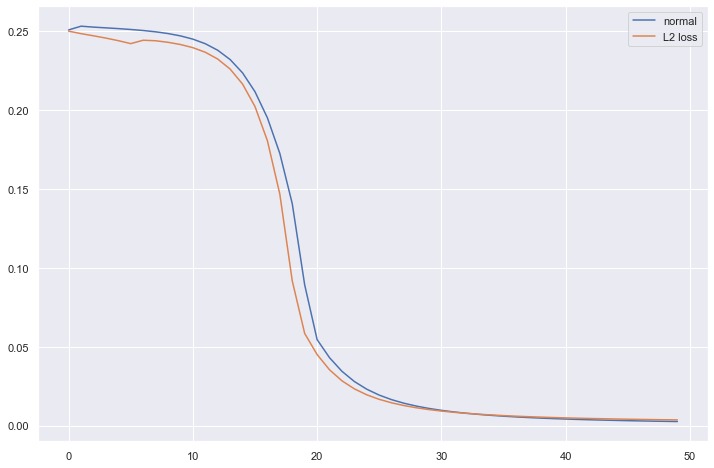

In [13]:
plt.plot(loss_normal,  label='normal')
plt.plot(loss_l2, label='L2 loss')
plt.legend(loc='upper right')
plt.show()

# 4.0.3. Dropout

**Dropout** is the poster boy of neural network regularization. Geoffrey Hinton on bank's fraud prevention mechanism:

> *"I went to my bank. The tellers kept changing and I asked one of them why. He said he didn't know but they got moved around a lot. 
>
> I figured it must be because it would require cooperation between employees to succesfully defraud the bank. 
>
> This made me realize that randomly removing a difference subsset of neurons on each example would prevent conspiracies and thus reduce overfitting"

[Geoffrey Hinton (in Reddit AMA)](https://www.reddit.com/r/MachineLearning/comments/4w6tsv/ama_we_are_the_google_brain_team_wed_love_to/)


To prevent the model from over-memorizing the data, adding random zero-ing noise to the output values of the layer will prevent *"conspiracies among neurons"*.

In [15]:
def MLP_Dropout(hidden_dim, num_epochs=5000, dropout=0.1):
    # Step 1: Initialization. 
    # Use Sequential to define a simple feed-forward network.
    model = nn.Sequential(
                # Use nn.Linear to get our simple perceptron.
                nn.Linear(input_dim, hidden_dim),
                nn.Dropout(dropout), 
                # Use nn.Sigmoid to get our sigmoid non-linearity.
                nn.Sigmoid(),
                # Second layer neurons.
                nn.Linear(hidden_dim, output_dim),
                nn.Sigmoid()
            ).to(device)
    # Initialize the optimizer
    learning_rate = 0.3
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    # Initialize the loss function.
    criterion = nn.MSELoss()
    # Initialize the stopping criteria
    # For simplicity, just stop training after certain no. of epochs.
    losses = [] # Keeps track of the loses.
    # Step 2-4 of training routine.
    for _e in tqdm(range(num_epochs)):
        # Reset the gradient after every epoch. 
        optimizer.zero_grad() 
        # Step 2: Foward Propagation
        predictions = model(X)
        # Step 3: Back Propagation 
        # Calculate the cost between the predictions and the truth.
        loss = criterion(predictions, Y)
        # Remember to back propagate the loss you've computed above.
        loss.backward()
        # Step 4: Optimizer take a step and update the weights.
        optimizer.step()
        # Log the loss value as we proceed through the epochs.
        if _e % 100 == 0:
            losses.append(loss.data.item())
    return losses


In [16]:
loss_normal = MLP(1000)
loss_droptout = MLP_Dropout(1000, dropout=0.5)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 658.44it/s]


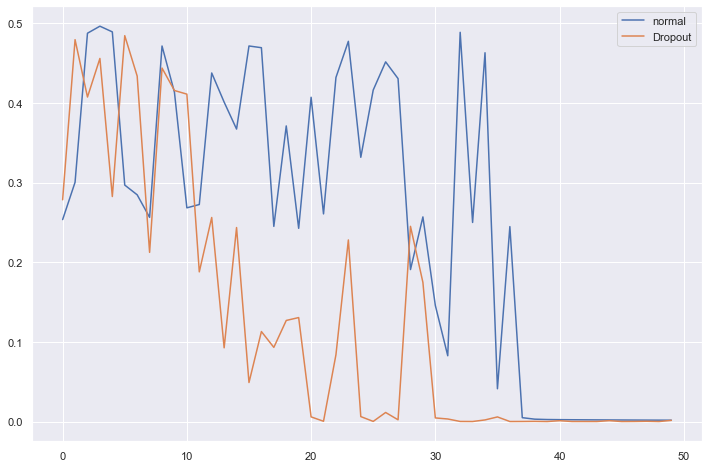

In [17]:
# Even at higher no. of parameter, 
# training is stable with quite a high dropout.
plt.plot(loss_normal,  label='normal')
plt.plot(loss_droptout, label='Dropout')
plt.legend(loc='upper right')
plt.show()

In [18]:
import sys
sys.executable

'D:\\apps\\Anaconda3\\envs\\torch-nlp\\python.exe'

In [15]:
! pip3 install -U --user tensorboard tensorboardX

  Using cached https://files.pythonhosted.org/packages/76/54/99b9d5d52d5cb732f099baaaf7740403e83fe6b0cedde940fabd2b13d75a/tensorboard-2.0.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a6/5c/e918d9f190baab8d55bad52840d8091dd5114cc99f03eaa6d72d404503cc/tensorboardX-1.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/b8/88def36e74bee9fce511c9519571f4e485e890093ab7442284f4ffaef60b/google_auth_oauthlib-0.4.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/cb/786dc53d93494784935a62947643b48250b84a882474e714f9af5e1a1928/google_auth-1.7.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2a/a0/ab76a2314e06356346ab411f7797debde31cd89bc5f2a4541a5955fe5ff4/grpcio-1.25.0-cp36-cp36m-macosx_10_9_x86_64.whl
ERROR: google-cloud 0.32.0 has requirement google-api-core<0.2.0dev,>=0.1.2, but you'll have google-api-core 1.10.0 which is incompatible.
ERROR: google-cloud 0.32.0 has requirement 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Found existing installation: grpcio 1.24.1
    Uninstalling grpcio-1.24.1:
      Successfully uninstalled grpcio-1.24.1
  Found existing installation: tensorboard 2.0.0
    Uninstalling tensorboard-2.0.0:
      Successfully uninstalled tensorboard-2.0.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# TensorboardX

First, install `Tensorboard`:

```
pip3 install -U --user tensorboard
```


Using `TensorboardX` ( https://github.com/lanpa/tensorboardX ), a PyTorch wrapper for https://www.tensorflow.org/guide/summaries_and_tensorboard


In command line:

```
python3 -m tensorboard.main --logdir='./logs' --reload_interval --port 6006
```


Then open a page on the browser to:

```
localhost:6006
```

Then run the code below

In [16]:
from tensorboardX import SummaryWriter

gradients = []
hidden_dim = 200
num_epochs = 5000

#writer = SummaryWriter('./logs')


# Step 1: Initialization. 
# Use Sequential to define a simple feed-forward network.
model = nn.Sequential(
            # Use nn.Linear to get our simple perceptron.
            nn.Linear(input_dim, hidden_dim),
            # Use nn.Sigmoid to get our sigmoid non-linearity.
            nn.Sigmoid(),
            # Second layer neurons.
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
# Initialize the optimizer
learning_rate = 0.3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Initialize the loss function.
criterion = nn.MSELoss()

#writer.add_graph(model, torch.zeros(*X.shape), True)

# Initialize the stopping criteria
# For simplicity, just stop training after certain no. of epochs.
losses = [] # Keeps track of the loses.
# Step 2-4 of training routine.
for _e in tqdm(range(num_epochs)):
    # Reset the gradient after every epoch. 
    optimizer.zero_grad() 
    # Step 2: Foward Propagation
    predictions = model(X)
    
    #for name, param in model.named_parameters():
    #    writer.add_histogram(name, param.clone().cpu().data.numpy(), _e)
    
    # Step 3: Back Propagation 
    # Calculate the cost between the predictions and the truth.
    loss = criterion(predictions, Y)
    # Remember to back propagate the loss you've computed above.
    loss.backward()
    # Step 4: Optimizer take a step and update the weights.
    optimizer.step()
    # Log the loss value as we proceed through the epochs.
    if _e % 100 == 0:
        losses.append(loss.data.item())
        #writer.add_scalar('Train/Loss', loss.data.item(), _e)

#writer.close()

100%|██████████| 5000/5000 [00:01<00:00, 2679.40it/s]


# [Optional] Now lets use TensorboardX on Word2Vec

Go back to Session3 code, recode these components:

 - Get the data from `Language is never ever random`.
 - Recode the `Word2VecDataset`
 - Recode the `CBOW` and `Skipgram` models
 - Recode the training routine, `model(x); loss.backward(); optimizer.step()` etc. 

On top of that launch the TensorboardX and see explore.